In [1]:
!pip install yfinance
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15191 sha256=f05ff2497ab90bfd83487ab2d747727cff5a6a8b606fa8fd5c32948dc3e10be0
  Stored in directory: /root/.cache/pip/wheels/4b/63/46/e7110bfee88685fe69e338d1b14d1748921862aa57b6705b60
Successfully built yahoofinancials


In [18]:
import numpy as np
import time as tm
import datetime 
import tensorflow as tf
import pandas as pd
# Data preparation
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

import yfinance as yf
from yahoofinancials import YahooFinancials
import time
from google.colab import files

In [3]:
#time to pull the data
start_date =datetime.datetime.today().strftime('%Y-%m-%d')
end_date = (datetime.datetime.today() - datetime.timedelta(days=1100)).strftime('%Y-%m-%d')

In [4]:
# calling API 
data=YahooFinancials('BTC-USD').get_historical_price_data(end_date,start_date,"daily")
#into the dataframe
btc_df = pd.DataFrame(data['BTC-USD']['prices'])

btc_df =btc_df .drop(['high','low','open','volume','date','adjclose'], axis=1)
btc_df.rename(columns={'formatted_date':'date'},inplace=True)
btc_df['date']=pd.to_datetime(btc_df['date'])

In [5]:
# SETTINGS
today=start_date =datetime.datetime.today()
day1=(today+datetime.timedelta(days=1)).strftime('%Y-%m-%d')
day2=(today+datetime.timedelta(days=2)).strftime('%Y-%m-%d')
day3=(today+datetime.timedelta(days=3)).strftime('%Y-%m-%d')

crypto='BTC'
# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

In [6]:
btc_df

,close,date
0,8757.788086,2019-11-11
1,8815.662109,2019-11-12
2,8808.262695,2019-11-13
3,8708.094727,2019-11-14
4,8491.992188,2019-11-15
...,...,...
1096,17034.292969,2022-11-11
1097,16799.185547,2022-11-12
1098,16353.365234,2022-11-13
1099,16618.199219,2022-11-14


In [7]:
btc_df.dtypes

close           float64
date     datetime64[ns]
dtype: object

In [8]:
# Scale data for ML engine
scaler = MinMaxScaler()
btc_df['scaled_close'] = scaler.fit_transform(np.expand_dims(btc_df['close'].values, axis=1))
btc_df

,close,date,scaled_close
0,8757.788086,2019-11-11,0.060499
1,8815.662109,2019-11-12,0.061424
2,8808.262695,2019-11-13,0.061305
3,8708.094727,2019-11-14,0.059705
4,8491.992188,2019-11-15,0.056253
...,...,...,...
1096,17034.292969,2022-11-11,0.192720
1097,16799.185547,2022-11-12,0.188964
1098,16353.365234,2022-11-13,0.181842
1099,16618.199219,2022-11-14,0.186073


In [9]:
def PrepareData(days):
    df = btc_df.copy()
    df['future'] = df['scaled_close'].shift(-days)
    last_sequence = np.array(df[['scaled_close']].tail(days))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)
    
    for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == N_STEPS:
            sequence_data.append([np.array(sequences), target])
            
    last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    # construct the X's and Y's
    X, Y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        Y.append(target)

   # convert to numpy arrays
    X = np.array(X)
    Y = np.array(Y)
    
    return df, last_sequence, X, Y

In [10]:
PrepareData(0) # 3 days


(             close       date  scaled_close    future
 0      8757.788086 2019-11-11      0.060499  0.060499
 1      8815.662109 2019-11-12      0.061424  0.061424
 2      8808.262695 2019-11-13      0.061305  0.061305
 3      8708.094727 2019-11-14      0.059705  0.059705
 4      8491.992188 2019-11-15      0.056253  0.056253
 ...            ...        ...           ...       ...
 1096  17034.292969 2022-11-11      0.192720  0.192720
 1097  16799.185547 2022-11-12      0.188964  0.188964
 1098  16353.365234 2022-11-13      0.181842  0.181842
 1099  16618.199219 2022-11-14      0.186073  0.186073
 1100  16975.482422 2022-11-15      0.191780  0.191780
 
 [1101 rows x 4 columns], array([[0.17429206],
        [0.20154603],
        [0.19271994],
        [0.188964  ],
        [0.1818418 ],
        [0.18607265],
        [0.19178042]], dtype=float32), array([[[0.06049903472546757, Timestamp('2019-11-11 00:00:00')],
         [0.06142359837839807, Timestamp('2019-11-12 00:00:00')],
         [0

In [11]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [12]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
137/137 [==============================] - 7s 17ms/step - loss: 0.0078
Epoch 2/80
137/137 [==============================] - 3s 21ms/step - loss: 0.0035
Epoch 3/80
137/137 [==============================] - 3s 23ms/step - loss: 0.0031
Epoch 4/80
137/137 [==============================] - 3s 24ms/step - loss: 0.0023
Epoch 5/80
137/137 [==============================] - 4s 26ms/step - loss: 0.0023
Epoch 6/80
137/137 [==============================] - 4s 26ms/step - loss: 0.0027
Epoch 7/80
137/137 [==============================] - 4s 28ms/step - loss: 0.0021
Epoch 8/80
137/137 [==============================] - 4s 27ms/step - loss: 0.0020
Epoch 9/80
137/137 [==============================] - 4s 27ms/step - loss: 0.0022
Epoch 10/80
137/137 [==============================] - 4s 29ms/step - loss: 0.0019
Epoch 11/80
137/137 [==============================] - 4s 26ms/step - loss: 0.0019
Epoch 12/80
137/137 [==============================] - 4s 29ms/step - loss: 0.0017
Epoch 13/80
1

In [19]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f' prediction for upcoming 3 days ({predictions_str})'
  
  print(message)

 prediction for upcoming 3 days (16312.69$, 17859.83$, 17637.45$)


In [20]:
# saving the file
days=[day1,day2,day3]
btc_lstm=pd.DataFrame()
btc_lstm['future days']=days
btc_lstm['price']=predictions
btc_lstm['ticker']='BTC'

btc_lstm.to_csv('btc_lstm.csv') 
files.download('btc_lstm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

35/35 [==============================] - 0s 6ms/step


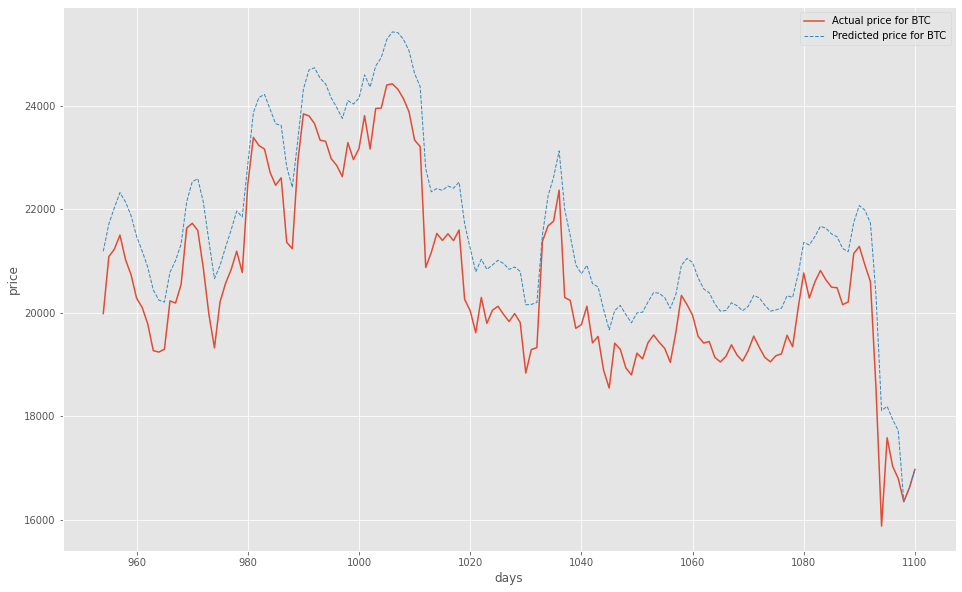

In [21]:
# Execute model for the whole history range
copy_df = btc_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed


copy_df.loc[day1] = [predictions[0], f'{day1}', 0, 0]
copy_df.loc[day2] = [predictions[1], f'{day2}', 0, 0]
copy_df.loc[day3] = [predictions[2], f'{day3}', 0, 0]

# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
# plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {crypto}', 
            f'Predicted price for {crypto}',
            f'Predicted price for future 3 days'])
plt.show()